This notebook will have code to load the previously saved models, generate data and evaluate it's usefullness.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier as gboost, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve)

from sklearn.preprocessing import LabelEncoder

from keras.models import load_model
from functools import partial

pd.options.display.max_rows = 4000

#Defining functions 

def scalex(X):
    """ normalize between 0 and 1 the values in X """
    nmin, nmax = 0.0, 1.0
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (nmax - nmin) + nmin
    return X_scaled
#
# Last card of scalex.
#

def generate_samples(generator_model, noise_dim, num_samples):
    """ generate samples to be used for futher analysis """
    return generator_model.predict(np.random.rand(num_samples, noise_dim))


def create_normalized_dataframe(df, attack_name):
    df_new = df.loc[df[" Label"] == attack_name]

    features = []
    for n in range(len(lbl)-1):
        m = lbl[n]
        tmp = np.unique(df_new[m])
        if (len(tmp) > 1):
            features.append(m)

    # normalize each field independently
    df_attack_norm = df_new
    for n in range(len(lbl)-1):
        m = lbl[n]
        if (np.max(df_attack_norm[m]) > 1).any(): 
            if (len(np.unique(df_attack_norm[m])) > 1):
                df_attack_norm[m] = scalex(df_attack_norm[m])
            else:
                df_attack_norm[m] = np.int64(1)  

    return df_attack_norm


df = pd.read_csv('./data/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", header=None, low_memory=False)

df = df.dropna()

df.columns = df.iloc[0]
df = df[1:]

df = df.apply(pd.to_numeric, errors='ignore')

label_counts = df[' Label'].value_counts()
print(label_counts)

lbl = df.columns

Using TensorFlow backend.
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

BENIGN         431873
FTP-Patator      7938
SSH-Patator      5897
Name:  Label, dtype: int64


In [2]:
attack_name = "SSH-Patator"
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_attack_norm = df_attack_norm.dropna()

MAX_SIM = 5897 #10293 #10000

X_train = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])
np.random.shuffle(X_train)

noise_dim = X_train.shape[1]

generator = load_model('SSH-Patator-Generator.h5')
discriminator = load_model('SSH-Patator-Discrimantor.h5')

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Instructions for updating:
Colocations handled automatically by placer.


c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
generated_samples=generate_samples(generator, noise_dim, MAX_SIM)

df_generated_samples = pd.DataFrame(generated_samples)

df_original = df_attack_norm.iloc[:MAX_SIM, :-1]

df_generated_samples.columns = df_original.columns

print(df_generated_samples)

unique_samples = np.unique(df_generated_samples, axis=0)
print(f"Number of unique samples: {len(unique_samples)}")

unique_samples_original = np.unique(df_original, axis=0)
print(f"Number of unique samples in original data: {len(unique_samples_original)}")

0      Destination Port   Flow Duration   Total Fwd Packets  \
0              0.998765        0.134890            0.718927   
1              1.025108       -0.006356           -0.000917   
2              1.011011        0.113027            0.620448   
3              1.017394       -0.004972            0.000920   
4              1.019921       -0.005426            0.000318   
...                 ...             ...                 ...   
5892           1.008092       -0.003303            0.003136   
5893           1.026067        0.114353            0.641318   
5894           1.029631        0.115307            0.647326   
5895           1.030322        0.115490            0.648503   
5896           1.008670        0.112255            0.614797   

0      Total Backward Packets  Total Length of Fwd Packets  \
0                    0.893677                     0.642136   
1                    0.033378                     0.003305   
2                    0.706316                     0.52664

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       1.00      1.00      1.00       977

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[1023    0]
 [   0  977]]
Accuracy:  1.0
ROC AUC:  1.0


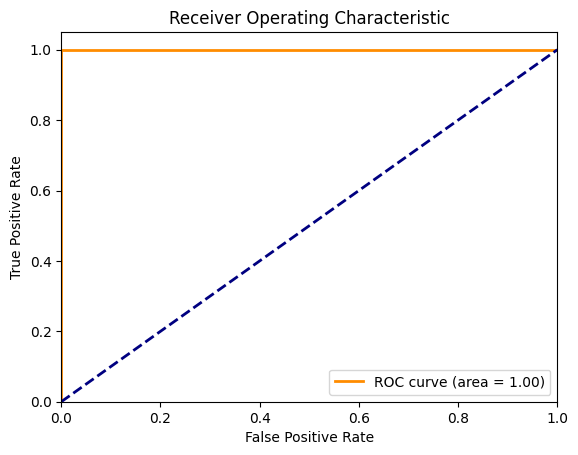

In [4]:
#Classification between benign and attack traffic

num_rows = 5000
attack_name = "SSH-Patator"
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_benign_norm = df_benign_norm.dropna()
df_attack_norm = df_attack_norm.dropna()


combined_df = pd.concat([df_attack_norm[:num_rows], df_benign_norm[:num_rows]])
combined_df = combined_df.sample(frac=1)

y = combined_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(combined_df.iloc[:,:-1], \
                                                    y, test_size=.2, random_state=42)


# Instantiate the encoder
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


# Create a Random Forest classifier object
classifier = RandomForestClassifier()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
 [[5000    0]
 [  16 4984]]
Accuracy:  0.9984
ROC AUC:  0.9984


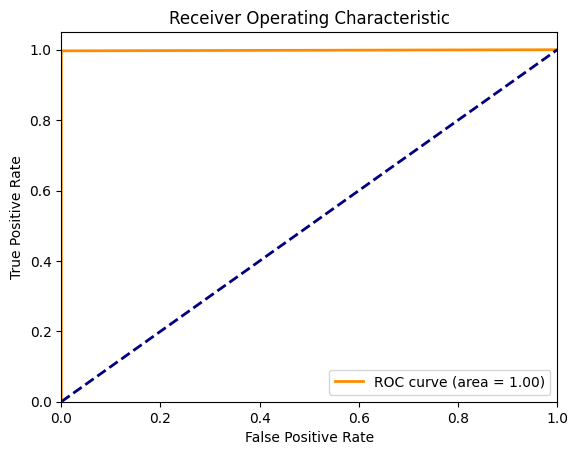

In [5]:
#Now training on generated and testing with real.

num_train_rows = 5000
num_test_rows = 5000
attack_name = "SSH-Patator"
lbl = df.columns
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_benign_norm = df_benign_norm.dropna()
df_attack_norm = df_attack_norm.dropna()

df_generated_samples[' Label'] = "SSH-Patator"
df_gensamples_norm = create_normalized_dataframe(df_generated_samples, attack_name)

df_train = pd.concat([df_gensamples_norm[:num_train_rows], df_benign_norm[:num_train_rows]])
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


# Use original data for testing
df_test = pd.concat([df_attack_norm[:num_test_rows], df_benign_norm[num_train_rows:num_train_rows+num_test_rows]])
#df_test = pd.concat([df_attack_norm[:num_test_rows], df_benign_norm[:num_train_rows]])
df_test = df_test.sample(frac=1)


X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


# Instantiate the encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Random Forest classifier object
classifier = gboost()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[1000    0]
 [   0 1000]]
Accuracy:  1.0
ROC AUC:  1.0


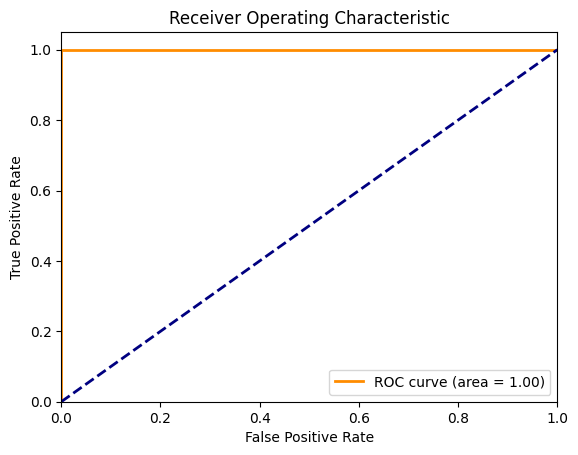

In [6]:
#Train with both.
#Test with real.
#Classifier between normal and attack data

num_train_rows = 8000
num_test_rows = 1000
num_test_rows_attack = 1000

gen_in_train = 4000
real_in_train = 4000

attack_name = "SSH-Patator"
df_generated_samples[' Label'] = "SSH-Patator"
lbl = df.columns

df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_gensamples_norm = create_normalized_dataframe(df_generated_samples, attack_name)

df_benign_norm = df_benign_norm.dropna()

df_training_mix = pd.concat([df_attack_norm[:real_in_train], df_gensamples_norm[:gen_in_train]])

df_train = pd.concat([df_training_mix[:num_train_rows], df_benign_norm[:num_train_rows]])
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


# Use original data for testing
df_test = pd.concat([df_attack_norm[real_in_train:real_in_train + num_test_rows_attack], df_benign_norm[num_train_rows:num_train_rows+num_test_rows]])
df_test = df_test.sample(frac=1)


X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


# Instantiate the encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Random Forest classifier object
classifier = gboost()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()